# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## Finishing off with Random Forests & Ensemble

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.items import Item 
#from loaders import ItemLoader
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.loaders import ItemLoader
#from testing import Tester
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [7]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)
    print(len(test))

49163


In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Can you spot the difference from what we did in Week 6? In week 6 we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [8]:
# This next line takes an hour on my M1 Mac!

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [9]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [10]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

In [13]:
# from agents.specialist_agent import SpecialistAgent
# from agents.frontier_agent import FrontierAgent
# from agents.random_forest_agent import RandomForestAgent
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week8.agents.specialist_agent import SpecialistAgent
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week8.agents.frontier_agent import FrontierAgent
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week8.agents.random_forest_agent import RandomForestAgent

In [15]:
#specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [16]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [18]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $79.33 Truth: $13.99 Error: $65.34 SLE: 2.82 Item: Kastar NP-FH50 Battery (1-Pack) and Char...
2: Guess: $96.62 Truth: $699.00 Error: $602.38 SLE: 3.88 Item: Sony a5100 16-50mm Mirrorless Digital Ca...
3: Guess: $147.87 Truth: $69.99 Error: $77.88 SLE: 0.55 Item: 1Mii 2.4Ghz Wireless Audio Transmitter R...
4: Guess: $201.19 Truth: $64.95 Error: $136.24 SLE: 1.26 Item: Fotodiox Pro Lens Mount Adapter - Bronic...
5: Guess: $128.49 Truth: $110.90 Error: $17.59 SLE: 0.02 Item: FOSA 10" Car Digital TV, ATSC Portable H...
6: Guess: $101.04 Truth: $5.99 Error: $95.05 SLE: 7.19 Item: Pineapple Vinyl Decal - Laptop, Decor, W...
7: Guess: $170.26 Truth: $529.00 Error: $358.74 SLE: 1.28 Item: Canon EOS 50D 15.1MP Digital SLR Camera ...
8: Guess: $48.59 Truth: $14.98 Error: $33.61 SLE: 1.28 Item: UpBright New Global 5V AC/DC Adapter Com...
9: Guess: $91.61 Truth: $113.99 Error: $22.38 SLE: 0.05 Item: OEM Electrolux Dryer Lint Filter Screen ...
10: Guess: $210.93 Truth: $829.99 Error: $61

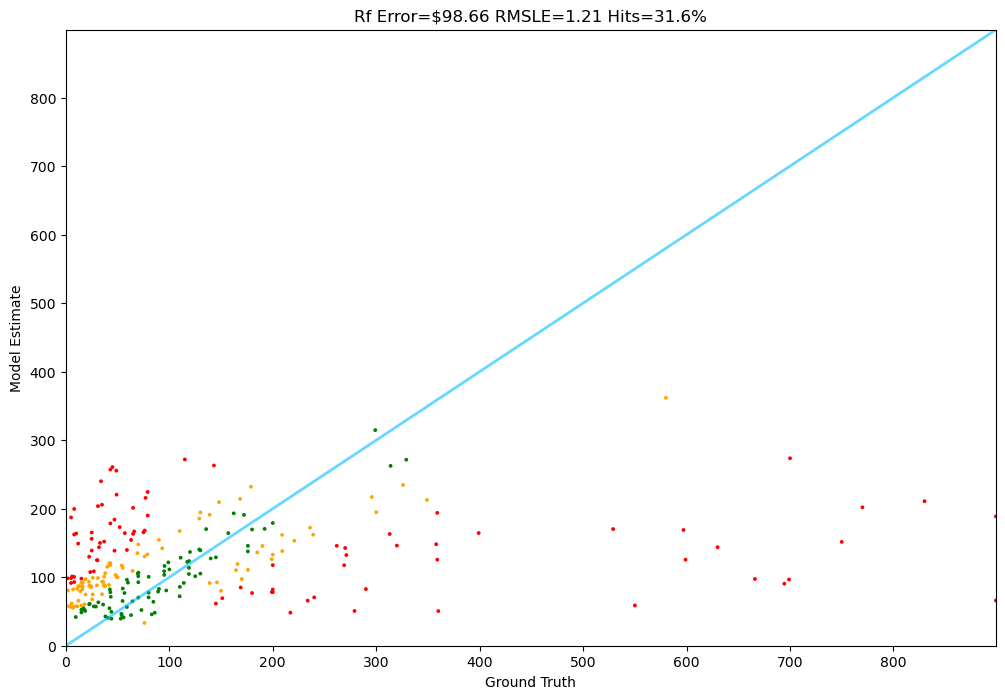

In [19]:
Tester.test(rf, test)

In [20]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [21]:
#print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

139.0
133.08434999999994


In [22]:
#specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    #specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|██████████| 250/250 [03:26<00:00,  1.21it/s]


In [25]:
#mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
#maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
mins = [min(f,r) for f,r in zip(frontiers, random_forests)]
maxes = [max(f,r) for f,r in zip(frontiers, random_forests)]

X = pd.DataFrame({
    #'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [26]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Frontier: 0.63
RandomForest: -0.12
Min: 0.57
Max: -0.06
Intercept=33.19


In [27]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [30]:
#from agents.ensemble_agent import EnsembleAgent
#from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week8.agents.ensemble_agent import EnsembleAgent
#ensemble = EnsembleAgent(collection)

In [ ]:
ensemble.price(product)

In [ ]:
def ensemble_pricer(item):
    return ensemble.price(description(item))

In [ ]:
Tester.test(ensemble_pricer, test)

# WHAT A DAY!

We got so much done - a Fronter RAG pipeline, a Random Forest model using transformer-based encodings, and an Ensemble model.

You can do better, for sure!

Tweak this, and try adding components into the ensemble, to beat my performance.